# Data Story

This first code cell will get our dataset and complete the data wrangling described in a different file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

dat = pd.concat([pd.read_csv('ss15hnd.csv'), pd.read_csv('ss15hny.csv'),
                 pd.read_csv('ss15hwy.csv'),
                 pd.read_csv('ss15htx.csv')], ignore_index = True)
dat.rename(columns = {"insp": "INSP"}, inplace = True)

colnames = ["ST", "NP", "ACR", "BATH", "BDSP", "ELEP", "GASP", "INSP",
              "RMSP", "RWAT", "SINK", "VALP", "VEH", "WATP", "YBL", "HINCP"]
readable_names = ["State", "Num_People", "Lot_Size", "Has_Bathtub", "Num_Bedrooms",
                  "Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Num_Rooms",
                  "Has_Hot_Water", "Has_Sink", "Price", "Num_Vehicles",
                  "Yearly_Water", "Year_Built", "Household_Income"]

cols = dat[colnames]
cols.columns = readable_names
cols.dropna(inplace = True)

cols = pd.get_dummies(cols, columns = ["State"])
readable_names = readable_names[1:]
states =["NY", "ND", "TX", "WY"]
readable_names.extend(states)
cols.columns = readable_names

codes = list(range(1,20))
ages = [90] + [i*10 for i in reversed(range(2,8))] + [13] + list(reversed(range(11)))
for code, age in zip(codes, ages):
    cols.Year_Built[cols.Year_Built == code] = age
cols.rename(columns={"Year_Built":"Age"}, inplace = True)

for col in ["Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Yearly_Water"]:
    cols.loc[:,col] *= dat.loc[cols.index, 'ADJHSG'] * 10**-6
    
cols.Household_Income *= dat.loc[cols.index, 'ADJINC'] * 10**-6

cols['Mobile_Home'] = pd.Series(dat.BLD == 1, dtype = 'int')

cols['Crowding'] = cols.Num_People / cols.Num_Rooms

cols.Num_Rooms -= cols.Num_Bedrooms

X = cols[[col for col in cols if col != 'Price']]
Y = cols.Price

/Users/hunter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hunter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


It will be enlightening to see the distribution of homes partitioned into extremely low priced (< 10,000 USD), low priced (10,000-99,999 USD), medium priced (100,000-499,999 USD), and high priced (> 500,000 USD). About 60% of the homes are in the medium priced category.

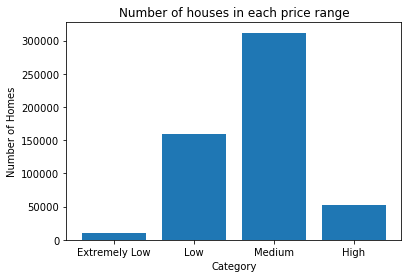

In [2]:
%matplotlib inline

cat_counts = [sum((Y>=a)&(Y<b)) for a,b in [(0,10000),
                                            (10000,100000),
                                            (100000,500000),
                                            (500000,10**20)]]

plt.bar(range(4),cat_counts)
plt.xlabel("Category")
plt.ylabel("Number of Homes")
plt.xticks(range(4),["Extremely Low", "Low", "Medium", "High"])
plt.title('Number of houses in each price range')

Perhaps there are unnecessary features in the dataset. I would like to see if the Crowding feature we have added is actually correlated in price.

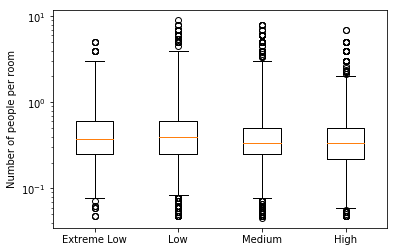

In [3]:
extreme_lows = X[Y<10000]
lows = X[(Y>=10000) & (Y<100000)]
mediums = X[(Y>=100000) & (Y<500000)]
highs = X[Y>=500000]

plt.boxplot([extreme_lows.Crowding, lows.Crowding, mediums.Crowding, highs.Crowding], whis=[0.1, 99.9])
plt.yscale('log')
plt.xticks(range(1,5), ['Extreme Low', 'Low', 'Medium', 'High'])
plt.ylabel("Number of people per room")

The boxplots below show that the median values are fairly close for each category but the extreme values for the Crowding variable give us some information on the price of the home. It appears that higher priced homes tend to not be overcrowded as often as lower priced homes.

PCA is an algorithm to reduce the dimensionality of a dataset. If we use PCA to reduce the dimensionality of the dataset to two we can then plot each sample in in a scatterplot and see if there is a clear pattern between classes.

In [28]:
Yclass = np.zeros(len(Y))
Yclass[Y < 10000] = 1
Yclass[(Y>=10000) & (Y<100000)] = 2
Yclass[(Y>=100000) & (Y<500000)] = 3
Yclass[Y>=500000] = 4
    
x, y = (PCA(n_components = 2).fit_transform(preprocessing.robust_scale(X,quantile_range=(5,95)))[:,i] for i in [0,1])

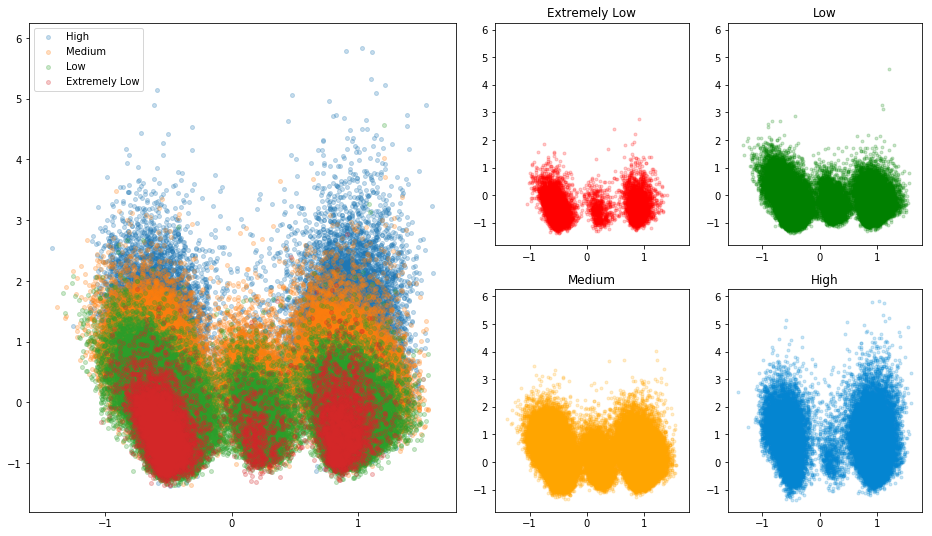

In [27]:
fig = plt.figure(figsize=(16,9))

ax0 = plt.subplot2grid((2,4),(0,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((2,4),(0,2), sharex=ax0, sharey=ax0)
ax2 = plt.subplot2grid((2,4),(0,3), sharex=ax0, sharey=ax0)
ax3 = plt.subplot2grid((2,4),(1,2), sharex=ax0, sharey=ax0)
ax4 = plt.subplot2grid((2,4),(1,3), sharex=ax0, sharey=ax0)

labels = ["High", "Medium", "Low", "Extremely Low"]

for i, label in enumerate(labels):
    ax0.scatter(x[Yclass==4-i],y[Yclass==4-i], alpha=0.25, s=16, label=label)
ax0.legend()
ax1.scatter(x[Yclass==1],y[Yclass==1], alpha=0.2, s=9, c='red')
ax2.scatter(x[Yclass==2],y[Yclass==2], alpha=0.2, s=9, c='green')
ax3.scatter(x[Yclass==3],y[Yclass==3], alpha=0.2, s=9, c='orange')
ax4.scatter(x[Yclass==4],y[Yclass==4], alpha=0.2, s=9, c='xkcd:cerulean')

labels = ["Extremely Low", "Low", "Medium", "High"]
axes = [ax1, ax2, ax3, ax4]

for ax, label in zip(axes, labels):
    ax.set_title(label)

According to the plots, there is a noticeable difference between the different categories. This is a good place to look into a classifier!